<a href="https://colab.research.google.com/github/naveenasokan/CNN-on-CIFR-Dataset/blob/master/Denoise_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import requests
from io import BytesIO
from skimage import io
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio



# **Adding Noise to the image**







In [116]:




def addnoise(SD,imgconv):
  patches =[]
  patchesy=[]

  SD=25
  img=imgconv
  H, W = img.shape[:-1]
  scale_h, scale_w = H//50 * 50, W//50 * 50
  resize_img = cv2.resize(img, (scale_w, scale_h), cv2.INTER_CUBIC)/255.0


  imgn=np.random.normal(scale=SD/255.0, size=(scale_w, scale_h, 3))+resize_img
  #creating subset of images for more training and validation
  for i in range(0, imgn.shape[0], patchsize):
    for j in range(0, imgn.shape[1], patchsize):
      patches.append(imgn[i:i+patchsize, j:j+patchsize, :])
      patchesy.append(resize_img[i:i+patchsize, j:j+patchsize, :])


  patches=np.array(patches)
  patchesy=np.array(patchesy)
  return patches,patchesy













# **Deep learning Architecture**





In [117]:
def get_model(depth=11, channels=3):
  noise_inp = tf.keras.layers.Input(shape = (None, None, channels), dtype=tf.float32, name = 'noiseinput')
  init = 'Orthogonal'

  y = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', kernel_initializer=init,
      use_bias=True)(noise_inp)
  y = tf.keras.layers.ReLU()(y)
  for i in range(1, depth-1):
      y = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', kernel_initializer=init,
          use_bias=True)(y)
      bn = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.95)
      y = bn(y)
      y = tf.keras.layers.ReLU()(y)
  residual = tf.keras.layers.Conv2D(filters = channels, kernel_size = 3, padding = 'same', kernel_initializer=init,
      use_bias=True, name='residual')(y)

  true_img = tf.keras.layers.Subtract()([noise_inp, residual])
  model = tf.keras.Model(inputs = [noise_inp], outputs=[true_img])
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

  return model


# **Reconstructing images for validation**

In [118]:
def reconstruct(patches,h,w,true_h,true_w):
  img = np.zeros((h,w, patches[0].shape[-1]))
  counter = 0
  for i in range(0,h,patchsize):
    for j in range(0,w,patchsize):
      img[i:i+patchsize, j:j+patchsize, :] = patches[counter]
      counter+=1
  return np.floor(cv2.resize(img, (true_w, true_h), cv2.INTER_CUBIC))*255.0




# **Call Back class for PSNR Validation**

In [119]:
class PSNECallback(Callback):
  def __init__(self,actual_data):
      super(PSNECallback, self).__init__()

      self.actual_data = actual_data
      self.output=[]



  def on_epoch_end(self, epoch, logs=None):
    finalpredimg=[]

    for act_img in self.actual_data:

        valid_x,valid_y = addnoise(SD,act_img)
        predimg=self.model.predict(valid_x)

        finalpredimg.append(reconstruct(predimg,predimg[0].shape[0],predimg[0].shape[1],act_img.shape[0],act_img.shape[1]))


    score = np.mean([peak_signal_noise_ratio(self.actual_data[i], finalpredimg[i]) for i in range(len(self.actual_data))])
    self.output=self.output+[[self.actual_data[i], finalpredimg[i]] for i in range(len(self.actual_data))]
    print(f'PSNR value for Predictions (std {SD}) : {score}')







# **Trainset-TRAIN400**
# **Validation-BSD68**

In [120]:

images_dir = '/content/drive/My Drive/Denoise cnn/'
train = glob.glob(images_dir+'Train400/*.png')
train=[cv2.imread(i) for i in train]
valid=glob.glob(images_dir+'BSD68/*.png')
valid=[cv2.imread(i) for i in valid]
train=np.array(train)
valid=np.array(valid)

<ipython-input-120-9459d605130d>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  valid=np.array(valid)


In [122]:
SD=25
patchsize=50

train_noise=[]
x_train=[]
y_train=[]
x_valid=[]
y_valid=[]
for i in train:
  x_t,y_t=addnoise(SD,i)
  x_train.extend(list(x_t))
  y_train.extend(list(y_t))





x_train=np.array(x_train)
y_train=np.array(y_train)
  #y_train.append(y_t)
#x_valid,y_valid=np.array(addnoise(SD,valid))




# **5 Epoch,loss as MSE**

In [124]:
model=get_model()
psnecallback=PSNECallback(valid)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
history = model.fit(x_train,y_train, steps_per_epoch=10, epochs=5, shuffle=True,verbose=1,
                callbacks=[psnecallback])

Epoch 1/5
2/2 [==============================] - 5s 1s/step
PSNR value for Predictions (std 25) : 5.906591688712546
10/10 [==============================] - 891s 90s/step - loss: 0.1546
Epoch 2/5


<ipython-input-119-51da138d7506>:21: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  score = np.mean([peak_signal_noise_ratio(self.actual_data[i], finalpredimg[i]) for i in range(len(self.actual_data))])


2/2 [==============================] - 2s 775ms/step
PSNR value for Predictions (std 25) : 6.088341931054066
10/10 [==============================] - 872s 90s/step - loss: 0.0158
Epoch 3/5
2/2 [==============================] - 2s 1s/step
PSNR value for Predictions (std 25) : 6.204507324187099
10/10 [==============================] - 884s 90s/step - loss: 0.0117
Epoch 4/5
2/2 [==============================] - 2s 766ms/step
PSNR value for Predictions (std 25) : 6.07143388077882
10/10 [==============================] - 930s 96s/step - loss: 0.0106
Epoch 5/5
2/2 [==============================] - 2s 821ms/step
PSNR value for Predictions (std 25) : 6.047658150028378
10/10 [==============================] - 870s 89s/step - loss: 0.0102


In [126]:
#model.save_weights('/content/drive/My Drive/Denoise cnn/Weights1')

In [127]:
#model.save('/content/drive/My Drive/Denoise cnn/modelcnn1')


In [225]:
def test_fnc(x_test):
  H, W = x_test[0].shape[:-1]
  scale_h, scale_w = H//50 * 50, W//50 * 50
  noise_test=[]
  test_y=[]
  for i in x_test:
    cl_img=cv2.resize(i, (scale_w, scale_h), cv2.INTER_CUBIC)/255
    imgn=np.random.normal(scale=SD/255.0, size=(scale_w, scale_h, 3))+cl_img
    noise_test.append(imgn)
    test_y.append(cl_img)
  noise_test=np.array(noise_test)
  test_y=np.array(test_y)
  predimg=model.predict(noise_test)

  return predimg,noise_test,test_y




In [226]:
test=glob.glob(images_dir+'Set12/*.png')
test=[cv2.resize(cv2.imread(i), (200, 200), cv2.INTER_CUBIC) for i in test]
test=np.array(test)

In [227]:
pred,noise,actual=test_fnc(test)

1/1 [==============================] - 10s 10s/step


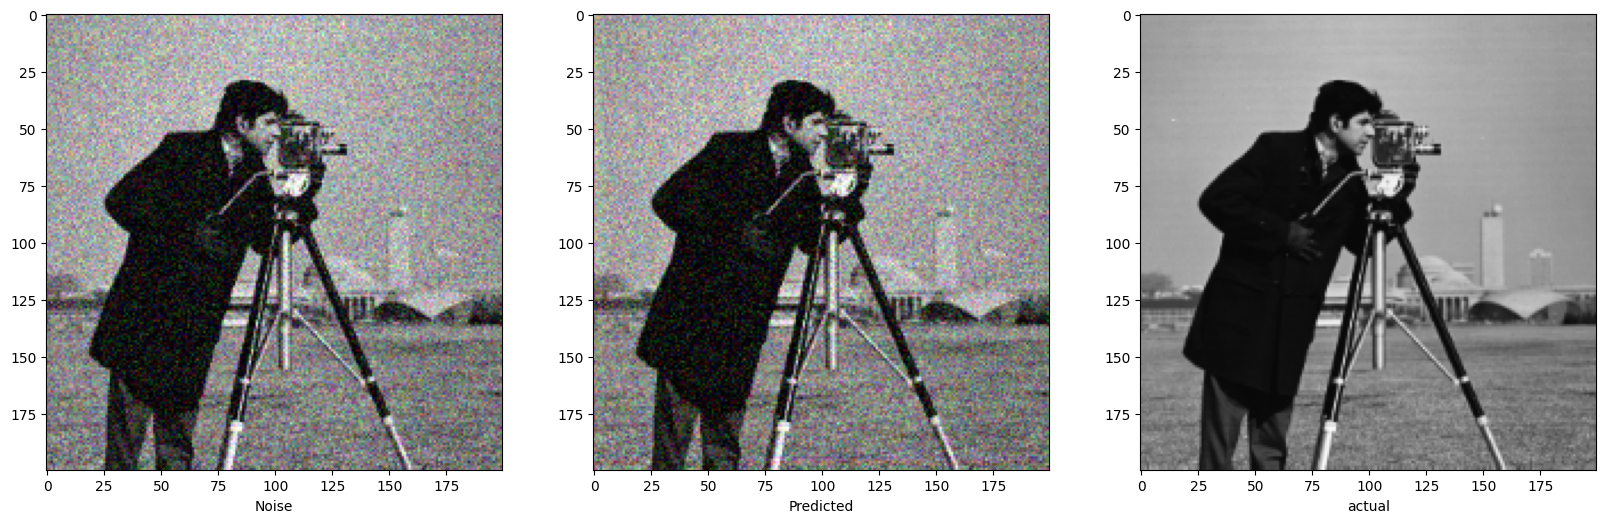

In [234]:
plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(noise[8])
plt.xlabel("Noise")
#plt.axis("off")

plt.subplot(1,3,2)

plt.xlabel("Predicted")
plt.imshow(pred[8])
#plt.axis("off")
plt.yticks=False

plt.subplot(1,3,3)
plt.xlabel("actual")
plt.imshow(actual[8])
#plt.axis("off")
plt.yticks=False


array([[[0.57254902, 0.57254902, 0.57254902],
        [0.59607843, 0.59607843, 0.59607843],
        [0.61176471, 0.61176471, 0.61176471],
        ...,
        [0.5372549 , 0.5372549 , 0.5372549 ],
        [0.50196078, 0.50196078, 0.50196078],
        [0.50588235, 0.50588235, 0.50588235]],

       [[0.59607843, 0.59607843, 0.59607843],
        [0.47843137, 0.47843137, 0.47843137],
        [0.39607843, 0.39607843, 0.39607843],
        ...,
        [0.53333333, 0.53333333, 0.53333333],
        [0.50196078, 0.50196078, 0.50196078],
        [0.49803922, 0.49803922, 0.49803922]],

       [[0.61960784, 0.61960784, 0.61960784],
        [0.52156863, 0.52156863, 0.52156863],
        [0.30196078, 0.30196078, 0.30196078],
        ...,
        [0.5254902 , 0.5254902 , 0.5254902 ],
        [0.51372549, 0.51372549, 0.51372549],
        [0.49803922, 0.49803922, 0.49803922]],

       ...,

       [[0.53333333, 0.53333333, 0.53333333],
        [0.50980392, 0.50980392, 0.50980392],
        [0.51764706, 0

In [210]:
pred[6]

array([[[0.57523215, 0.4985972 , 0.43808097],
        [0.42552522, 0.5133706 , 0.30896732],
        [0.36397952, 0.34482318, 0.5258822 ],
        ...,
        [0.4461861 , 0.30044302, 0.3949803 ],
        [0.4221709 , 0.55442536, 0.4695449 ],
        [0.3943988 , 0.31621334, 0.2967561 ]],

       [[0.464782  , 0.50170004, 0.42903858],
        [0.4696231 , 0.5114702 , 0.4481815 ],
        [0.6933776 , 0.49626145, 0.4846989 ],
        ...,
        [0.19112676, 0.3549913 , 0.30880147],
        [0.31718552, 0.35126093, 0.25379437],
        [0.32299173, 0.48052418, 0.24274044]],

       [[0.5442877 , 0.49364552, 0.32707465],
        [0.5473431 , 0.4855049 , 0.4366519 ],
        [0.52929115, 0.48144817, 0.5657654 ],
        ...,
        [0.44292268, 0.21874419, 0.5819224 ],
        [0.27140486, 0.33227518, 0.50109065],
        [0.15376142, 0.32554558, 0.29076856]],

       ...,

       [[0.65972304, 0.37471914, 0.36710954],
        [0.4600761 , 0.5893463 , 0.52413017],
        [0.5750773 , 0